# Workshop: *Anomaly detection from sensor data*

Course: NICF- Intelligent Sensing and Sense Making (SF)

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/intelligent-sensing-and-sense-making/analytics-and-intelligent-systems

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

In this workshop, we will perform following three tasks:
- Introduction to autoencoder model and Keras
- Perform anomaly detection using autoencoder as reconstruction model

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `issmv` or install additional packages in your own environment

**[Windows, CPU version]**

`conda create -n issmv python=3.6 numpy=1.15.1 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 notebook=5.7.4 pandas=0.24.2 pywavelets=1.0.2`

**[Windows, GPU version, CUDA 9.0]**

`conda create -n issmv python=3.6 numpy=1.15.1 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.2.4 notebook=5.7.4 pandas=0.24.2 pywavelets=1.0.2`

**[Google Colab]**

Refer to another notebook file `wk_abnormal_colab_v4.1.ipynb`

- Activate the environment `issmv`

`conda activate issmv`

- Browse to the folder that contains the workshop files, then run jupyter notebook

`jupyter notebook`


## Submission guideline

Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.

# Exercise 1: Build autoencoder model in Keras


In [1]:
import os
import numpy as np
import keras
import pickle
import pandas as pd
from keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


Using TensorFlow backend.


In [2]:
# Configuration on autoencoder model

# Dimension of input signal, determined by your test data
signal_dimension = 784 

# Dimension of encoded features, can be adjusted by user
encoder_dimension = 2

# training setup
EPOCHS = 5
BATCH_SIZE = 64


In [3]:
# Define an autoencoder model using Sequential method

def AE_method1(x_train):
    FINAL_DIM = 900
    data_dim = data_train.shape[1]
    autoencoder = Sequential()
    autoencoder.add(Dense(encoder_dimension, activation='relu', input_shape=(signal_dimension, ), name='layer1'))
    autoencoder.add(Dense(signal_dimension, activation='relu',name='layer2'))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
    
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('layer1').output)
    return encoder, autoencoder


In [4]:
# Show the encoding coefficients

def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n)
    for i in range(n):
        print(i, '-th image, encoding coefficients are ', latent_repr[i,:])
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(60000, 28, 28) (10000, 28, 28)


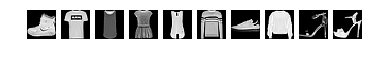

In [5]:
# For the first time of running this code, it will automatically download fashion_mnist data from Internet
# Load data
(data_train, label_train), (data_test, label_test) = fashion_mnist.load_data()
print(data_train.shape, data_test.shape)

# Normalize
data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.

# Plot the examples of original images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(data_train[i], cmap='gray')
    ax[i].axis('off')

plt.show()

data_train = data_train.reshape((data_train.shape[0], -1))
data_test = data_test.reshape((data_test.shape[0], -1))


In [6]:
# Demo autoencoder using method 1 (Sequential method)

model_encoder, model_autoencoder = AE_method1(x_train=data_train)
model_encoder.summary()
model_autoencoder.summary()


Epoch 1/5
60000/60000 [==============================] - 3s 56us/step - loss: 0.0985
Epoch 2/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.0917
Epoch 3/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0916
Epoch 4/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.0914
Epoch 5/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.0912
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape    

0 -th image, encoding coefficients are  [4.0504303  0.27439192]
1 -th image, encoding coefficients are  [11.448587   7.0580306]
2 -th image, encoding coefficients are  [0.7258463 9.854221 ]
3 -th image, encoding coefficients are  [0.       7.711817]
4 -th image, encoding coefficients are  [6.652237 4.346208]
5 -th image, encoding coefficients are  [2.655509 7.91049 ]


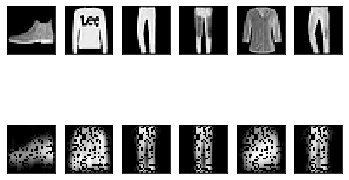

In [7]:
# Visualize the results and encoding coefficients

num_sample = 6 # Number of test samples used for visualization
data_encode = model_encoder.predict(data_test[:num_sample])

data_rec = model_autoencoder.predict(data_test)
show_encodings(data_test[:num_sample], data_encode, data_rec)


In [8]:
# Define an autoencoder model using Functional method

def AE_method2(x_train):
    # input placeholder
    input_image = Input(shape=(signal_dimension, ))

    # encoding layer
    hidden_layer = Dense(encoder_dimension, activation='relu')(input_image)

    # decoding layer
    decode_output = Dense(signal_dimension, activation='relu')(hidden_layer)

    # build autoencoder, encoder, decoder
    encoder = Model(inputs=input_image, outputs=hidden_layer)
    autoencoder = Model(inputs=input_image, outputs=decode_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return encoder, autoencoder


$\color{red}{\text{Q1. Complete the code to build autoencoder model and visualize the encoding coefficients.}}$

Tasks
- Build an autoencoder model using AE_method2()
- Plot the model summary
- Perform prediction using the first 5 test samples
- Visualize the original sample, encoding coefficients, reconstructed sample


In [9]:
# Provide your code to Q1 here




# Exercise 2: Machine health monitoring

Reference: R. Zhao, R. Yan, Z. Chen, K. Mao, P. Wang, R. Gao, Deep learning and its applications to machine health monitoring, Mechanical Systems and Signal Processing, Vol. 115, Jan. 2019, pp. 213-237.
- pdf paper, https://arxiv.org/abs/1612.07640
- code, https://github.com/ClockworkBunny/MHMS_DEEPLEARNING

In [10]:
# Configuration
encoder_dimension = 10
NUM_EPOCH = 10
BATH_SIZE = 24


In [11]:
# Define an autoencoder model using Sequantial method

def build_AE_machine(data_train):
    data_dim = data_train.shape[1]
    ae = Sequential()
    ae.add(Dense(encoder_dimension, activation='relu', input_shape=(data_dim, )))
    ae.add(Dense(encoder_dimension, activation='relu'))
    ae.add(Dense(data_dim, activation='relu'))
    ae.compile(optimizer='adam', loss='mse')
    ae.fit(data_train, data_train, epochs=NUM_EPOCH, batch_size=BATH_SIZE, shuffle=True)
    
    return ae


In [12]:
# Load data 
x_train_pd = pd.read_csv("data/machine_sensor_train.csv",header=None)
x_train = x_train_pd.values
x_test_pd = pd.read_csv("data/machine_sensor_test.csv",header=None)
x_test = x_test_pd.values

# Train the model
normal_AE = build_AE_machine(x_train)
normal_AE.summary()


Epoch 1/10
600/600 [==============================] - 0s 402us/step - loss: 0.5075
Epoch 2/10
600/600 [==============================] - 0s 95us/step - loss: 0.4567
Epoch 3/10
600/600 [==============================] - 0s 95us/step - loss: 0.4511
Epoch 4/10
600/600 [==============================] - 0s 93us/step - loss: 0.4504
Epoch 5/10
600/600 [==============================] - 0s 93us/step - loss: 0.4500
Epoch 6/10
600/600 [==============================] - 0s 93us/step - loss: 0.4498
Epoch 7/10
600/600 [==============================] - 0s 93us/step - loss: 0.4495
Epoch 8/10
600/600 [==============================] - 0s 93us/step - loss: 0.4492
Epoch 9/10
600/600 [==============================] - 0s 95us/step - loss: 0.4489
Epoch 10/10
600/600 [==============================] - 0s 93us/step - loss: 0.4485
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)       

In [13]:
sample_index = 0
thre = 10 # A manually-defined threshold

# Step 1: Select the test sample (such as the 0-th sample)
test_data_orig = x_test[sample_index:sample_index+1,:]
print(test_data_orig.shape)

# Step 2: Perform prediction using the trained autoencoder model
test_data_predict = normal_AE.predict(test_data_orig)

# Step 3: Calculate the reconstruction error and make decision on anomaly detection
dist = np.linalg.norm(test_data_orig - test_data_predict, axis=-1)

if (dist>thre):
    print('Anomaly detected: the distance is %.2f' % dist)
else:
    print('Normal: the distance is %.2f' % dist)
    

(1, 70)
Normal: the distance is 6.74


$\color{red}{\text{Q2. Complete the code to build autoencoder model for abnormal machine sensory signal detection.}}$

Tasks
- Build an autoencoder model using build_AE_machine()
- Peform the test on x_test and determine the test data (row index) with LARGEST reconstruction error based on your trained model


In [14]:
# Provide your code to Q2 here

# Build an autoencoder model (you can tune model configuration such as encoder_dimension)

# Perform prediction using the trained autoencoder model

# Calculate the reconstruction error and make decision on anomaly detection
# Determine the test data (row index) with LARGEST reconstruction error based on your trained model


**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!